### Imports


In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import time


### Data Exploration

In [44]:

# Reload the CSV file
file_path = "assignTTSWING.csv"
df = pd.read_csv(file_path)


In [45]:
# Filter only feature columns (exclude metadata and IDs)
feature_columns = [col for col in df.columns if col.startswith(('a_', 'g_', 'ax_', 'ay_', 'az_', 'gx_', 'gy_', 'gz_'))]
features = df[feature_columns]

# Assign the labels
testmode_labels = df['testmode'] if 'testmode' in df.columns else None
gender_labels = df['gender'] if 'gender' in df.columns else None
age_labels = df['age'] if 'age' in df.columns else None
playYears_labels = df['playYears'] if 'playYears' in df.columns else None
height_labels = df['height'] if 'height' in df.columns else None
weight_labels = df['weight'] if 'weight' in df.columns else None
handedness_labels = df['handedness'] if 'handedness' in df.columns else None
holdRacketHanded_labels = df['holdRacketHanded'] if 'holdRacketHanded' in df.columns else None

# Combine all labels into a single DataFrame
labels_df = pd.DataFrame({
    'testmode': testmode_labels,
    'gender' : gender_labels,
    'age' : age_labels,
    'playYears' : playYears_labels,
    'height' : height_labels,
    'weight' : weight_labels,
    'handedness' : handedness_labels,
    'holdRacketHanded' : holdRacketHanded_labels
})


In [46]:
# Convert all labels to string type
labels_df = labels_df.astype(str)

In [47]:
# Count how many of each label we have
label_counts = labels_df.apply(pd.Series.value_counts).fillna(0).astype(int)

# Print the label counts
print("Label counts:")
print(label_counts)

Label counts:
        testmode  gender    age  playYears  height  weight  handedness  \
0           7505   38555      0          0       0       0       16105   
1          73850   58800      0          0       0       0       81250   
2          16000       0      0          0       0       0           0   
???            0       0      5          5       5       5           0   
high           0       0  18150      23200   29100   29250           0   
low            0       0  26900      21250   27450   31500           0   
medium         0       0  52300      52900   40800   36600           0   

        holdRacketHanded  
0                  16105  
1                  81250  
2                      0  
???                    0  
high                   0  
low                    0  
medium                 0  


In [48]:
# Reveal the rows that are ??? for age, playYears, height, weight
missing_labels = labels_df[labels_df.isin(['???']).any(axis=1)]

# Print the rows with missing labels
print("\nRows with missing labels:")
print(missing_labels)

# Create a list of all the rows that are ??? for age, playYears, height, weight
missing_rows = missing_labels.index.tolist()

# Delete the rows with missing labels from the labels and features DataFrames
labels_df_cleaned = labels_df.drop(missing_rows)
features_cleaned = features.drop(missing_rows)


Rows with missing labels:
      testmode gender  age playYears height weight handedness holdRacketHanded
9999         0      0  ???       ???    ???    ???          0                0
19999        0      0  ???       ???    ???    ???          0                0
29999        0      0  ???       ???    ???    ???          0                0
39999        0      0  ???       ???    ???    ???          0                0
49999        0      0  ???       ???    ???    ???          0                0


In [49]:
# Recheck that the invalid rows are gone
# Count how many of each label we have
label_counts = labels_df_cleaned.apply(pd.Series.value_counts)

# Print the label counts
print("Label counts:")
print(label_counts)

Label counts:
        testmode   gender      age  playYears   height   weight  handedness  \
0         7500.0  38550.0      NaN        NaN      NaN      NaN     16100.0   
1        73850.0  58800.0      NaN        NaN      NaN      NaN     81250.0   
2        16000.0      NaN      NaN        NaN      NaN      NaN         NaN   
high         NaN      NaN  18150.0    23200.0  29100.0  29250.0         NaN   
low          NaN      NaN  26900.0    21250.0  27450.0  31500.0         NaN   
medium       NaN      NaN  52300.0    52900.0  40800.0  36600.0         NaN   

        holdRacketHanded  
0                16100.0  
1                81250.0  
2                    NaN  
high                 NaN  
low                  NaN  
medium               NaN  


In [50]:
# Finally assign the X_train, X_test, X_val, y_train, y_test, y_val
# We will use 60% of the data for training, 20% for testing, and 20% for validation
# The y_train will be the height inside of the labels_df
X_train, X_temp, y_train, y_temp = train_test_split(features_cleaned, labels_df_cleaned['height'], test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

In [51]:
# Check the sizes of the splits
print(f"X_train size: {X_train.shape}")
print(f"X_val size: {X_val.shape}")
print(f"X_test size: {X_test.shape}")

# Check the sizes of the splits
print(f"y_train size: {y_train.shape}")
print(f"y_val size: {y_val.shape}")
print(f"y_test size: {y_test.shape}")

# Check the ratios of the splits
print(f"X_train ratio: {X_train.shape[0] / features_cleaned.shape[0]}")
print(f"X_val ratio: {X_val.shape[0] / features_cleaned.shape[0]}")
print(f"X_test ratio: {X_test.shape[0] / features_cleaned.shape[0]}")

# Check the ratios of the splits
print(f"y_train ratio: {y_train.shape[0] / labels_df_cleaned.shape[0]}")
print(f"y_val ratio: {y_val.shape[0] / labels_df_cleaned.shape[0]}")
print(f"y_test ratio: {y_test.shape[0] / labels_df_cleaned.shape[0]}")


X_train size: (58410, 34)
X_val size: (19470, 34)
X_test size: (19470, 34)
y_train size: (58410,)
y_val size: (19470,)
y_test size: (19470,)
X_train ratio: 0.6
X_val ratio: 0.2
X_test ratio: 0.2
y_train ratio: 0.6
y_val ratio: 0.2
y_test ratio: 0.2


#### SMOTE

In [52]:
# Check how many 'low', 'medium', and 'high' labels we have in the y_train
y_train_counts = y_train.value_counts()

# Print the y_train counts with percentage
y_train_counts_percentage = y_train_counts / y_train_counts.sum() * 100
print("\nY_train counts with percentage:")
print(y_train_counts_percentage)

print("\nY_train counts:")
print(y_train_counts)



Y_train counts with percentage:
height
medium    42.033898
high      29.727786
low       28.238315
Name: count, dtype: float64

Y_train counts:
height
medium    24552
high      17364
low       16494
Name: count, dtype: int64


In [53]:
# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Keep validation and test sets unchanged
# X_val, y_val remain as they are
# X_test, y_test remain as they are

# Print class distributions
print("Original training set distribution:", pd.Series(y_train).value_counts())
print("Balanced training set distribution:", pd.Series(y_train_balanced).value_counts())
print("Validation set distribution:", pd.Series(y_val).value_counts())
print("Test set distribution:", pd.Series(y_test).value_counts())

Original training set distribution: height
medium    24552
high      17364
low       16494
Name: count, dtype: int64
Balanced training set distribution: height
medium    24552
high      24552
low       24552
Name: count, dtype: int64
Validation set distribution: height
medium    8135
high      5800
low       5535
Name: count, dtype: int64
Test set distribution: height
medium    8113
high      5936
low       5421
Name: count, dtype: int64


#### STANDARDIZEA THE FEATURES

In [54]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


### PCA

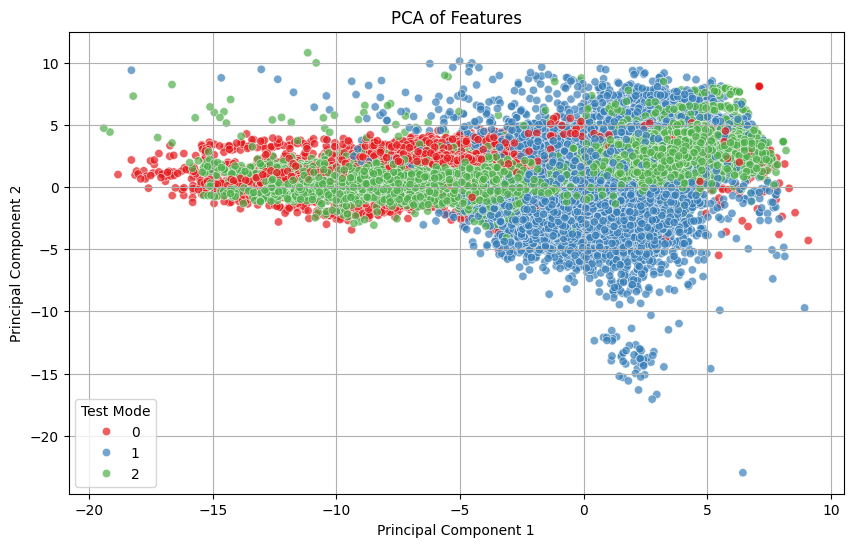

In [55]:
# Compute the PCA via the covariance matrix method

# Standardize the features
mean = features.mean()
std = features.std()
features_standardized = (features - mean) / std

# Compute the covariance matrix
cov_matrix = features_standardized.cov()

# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort the eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Perform dimensionality reduction by multiplying the data by the top two eigenvectors
pca_features = np.dot(features_standardized, sorted_eigenvectors[:, :2])
pca_features_df = pd.DataFrame(pca_features, columns=['PC1', 'PC2'])

# Plot the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_features_df, x='PC1', y='PC2', hue=testmode_labels, palette='Set1', alpha=0.7)
plt.title('PCA of Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Test Mode')
plt.grid()
plt.savefig('pca_features.png')
plt.show()



In [56]:

# Again but with feature changed into ndarray
features_np = features.values

# Standardize the features
mean = np.mean(features_np, axis=0)
std_dev = np.std(features_np, axis=0)
features_standardized_np = (features_np - mean) / std_dev

# Compute the covariance matrix
cov_matrix_np = np.cov(features_standardized_np.T)

# Compute the eigenvalues and eigenvectors
eigenvalues_np, eigenvectors_np = np.linalg.eig(cov_matrix_np)
sorted_indices = np.argsort(eigenvalues_np)[::-1]
eigenvalues = eigenvalues_np[sorted_indices]
eigenvectors = eigenvectors_np[:, sorted_indices]

# Perform dimensionality reduction by multiplying the data by the top two eigenvectors
reduced_features = np.dot(features_standardized_np, eigenvectors[:, :2])



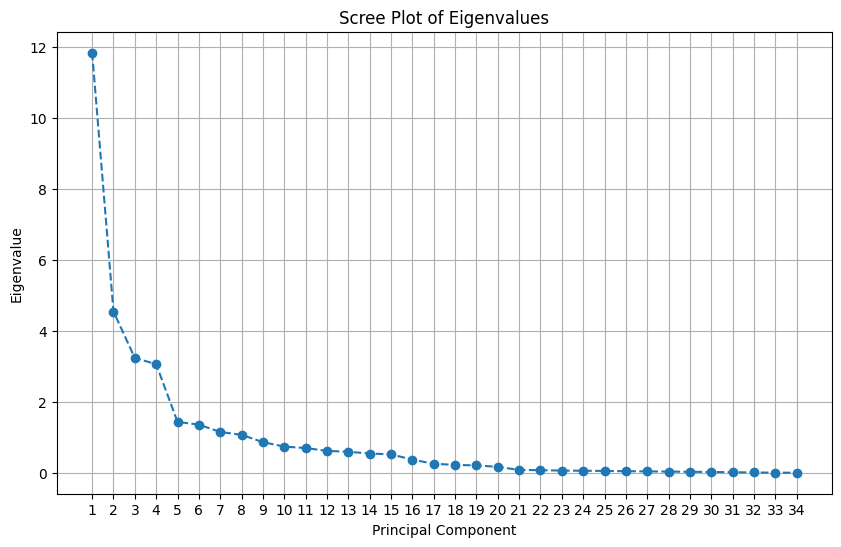

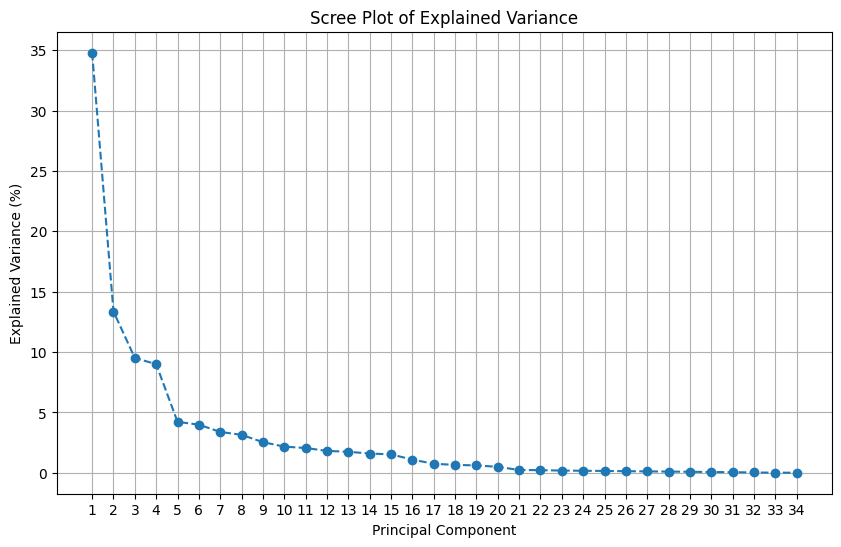

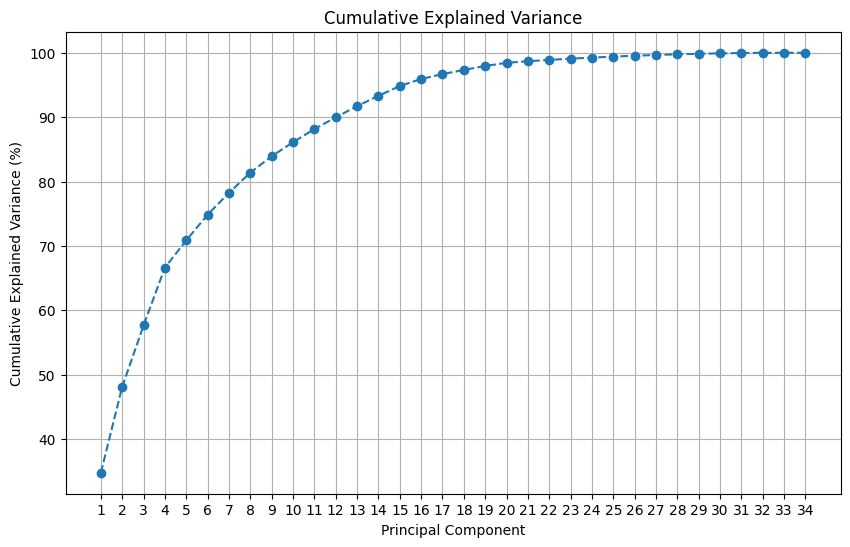

Total variance explained by all components: 100.00%


In [57]:
# Make a Scree graph for all eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.title('Scree Plot of Eigenvalues')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(eigenvalues) + 1))
plt.grid()
plt.savefig('scree_plot.png')
plt.show()

# Make another Scree graph for all eigenvalues but the y-axis is the percentage of variance explained
plt.figure(figsize=(10, 6))
explained_variance = eigenvalues / np.sum(eigenvalues) * 100
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot of Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()

# Make a cumulative explained variance plot
plt.figure(figsize=(10, 6))
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance (%)')
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.grid()
plt.show()

# Check that the percentages add up to 100%
total_variance = np.sum(explained_variance)
print(f"Total variance explained by all components: {total_variance:.2f}%")


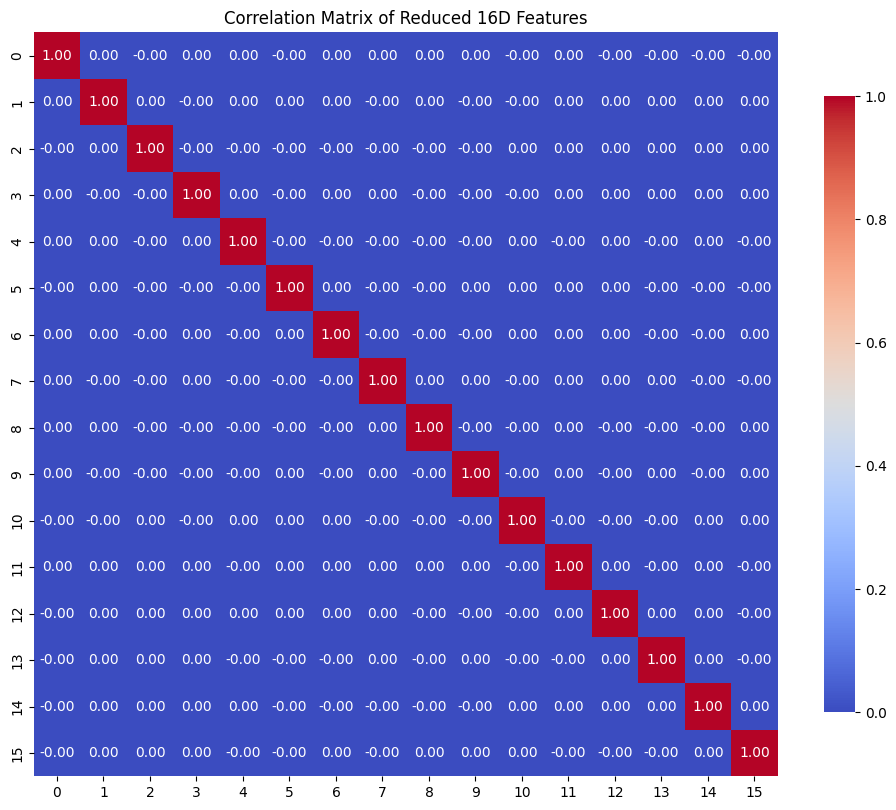

In [58]:
# Reduce the features to 16 dimensions using PCA
reduced_features_16 = np.dot(features_standardized_np, eigenvectors[:, :16])

# Plot the correlation matrix of the reduced 16D features
plt.figure(figsize=(12, 10))
sns.heatmap(np.corrcoef(reduced_features_16.T), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Reduced 16D Features')
plt.show()


In [59]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


### K-NN ALGORITHM

#### K-NN WITH ORIGINAL DATASET

In [60]:
def run_knn_from_split(X_train, X_test, y_train, y_test, n_neighbors=5, class_names=None, plot_confusion=False, verbose=False, label_name=""):
    # Fit KNN
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Accuracy and loss
    accuracy = accuracy_score(y_test, y_pred)
    loss = 1 - accuracy

    if verbose:
        print(f"\nK-NN Results for label: {label_name}")
        print(classification_report(y_test, y_pred, target_names=class_names))
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Loss: {loss:.4f}")

    if plot_confusion:
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix: {label_name}')
        plt.tight_layout()
        plt.show()

    return accuracy, loss, knn

# # Example usage:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

# label_of_interest = 'height'
# y = labels_df[label_of_interest].values
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)
# class_names = le.classes_

# # Split once
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
# )

# # Run KNN for k=1
# accuracy, loss, _ = run_knn_from_split(X_train, X_test, y_train, y_test, n_neighbors=1, class_names=class_names, label_name=label_of_interest)


n_neighbors=1: accuracy=0.8627, loss=0.1373
n_neighbors=2: accuracy=0.8447, loss=0.1553
n_neighbors=4: accuracy=0.8578, loss=0.1422
n_neighbors=8: accuracy=0.8551, loss=0.1449
n_neighbors=16: accuracy=0.8425, loss=0.1575
n_neighbors=32: accuracy=0.8201, loss=0.1799
n_neighbors=64: accuracy=0.7934, loss=0.2066
n_neighbors=128: accuracy=0.7467, loss=0.2533
n_neighbors=256: accuracy=0.6928, loss=0.3072
n_neighbors=512: accuracy=0.6274, loss=0.3726
n_neighbors=1024: accuracy=0.5648, loss=0.4352
n_neighbors=2048: accuracy=0.5169, loss=0.4831
n_neighbors=4096: accuracy=0.4612, loss=0.5388


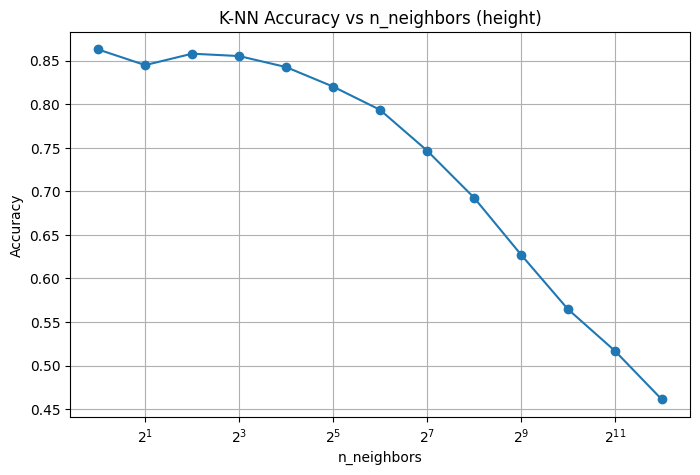

In [61]:
n_neighbors_list = [2**i for i in range(13)]
results = []

label_of_interest = 'height'  # any label you want

# Encode both training and test labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_balanced)  # Fit on training data
y_test_encoded = le.transform(y_test)  # Transform test data using same encoder
class_names = le.classes_

for n in n_neighbors_list:
    try:
        accuracy, loss, knn = run_knn_from_split(
            X_train_scaled, 
            X_test_scaled,  # Use scaled test data
            y_train_encoded,  # Use encoded training labels
            y_test_encoded,  # Use encoded test labels
            n_neighbors=n, 
            class_names=class_names, 
            label_name=label_of_interest
        )
        results.append({'n_neighbors': n, 'accuracy': accuracy, 'loss': loss, 'knn_model': knn})
        print(f"n_neighbors={n}: accuracy={accuracy:.4f}, loss={loss:.4f}")
    except ValueError as e:
        print(f"n_neighbors={n}: Error - {e}")

# Plot accuracy vs n_neighbors
plt.figure(figsize=(8, 5))
plt.plot([r['n_neighbors'] for r in results], [r['accuracy'] for r in results], marker='o')
plt.xscale('log', base=2)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title(f'K-NN Accuracy vs n_neighbors ({label_of_interest})')
plt.grid(True)
plt.show()

In [62]:
# Find the best KNN model (highest accuracy)
best_result = max(results, key=lambda x: x['accuracy'])
best_knn = best_result['knn_model']
best_n = best_result['n_neighbors']

# Predict on the test set using the best model
y_pred_best = best_knn.predict(X_test)

# Plot confusion matrix for the best model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix: Best KNN (n_neighbors={best_n}) for {label_of_interest}')
plt.tight_layout()
plt.show()

c:\Users\Volter\anaconda3\envs\DeepLearningSTAT7007\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


ValueError: Mix of label input types (string and number)

##### K-NN CROSS-VALIDATION



In [79]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier

# Combine X_train and X_test for X input into K-Fold
X_kfold = np.vstack((X_train, X_test))
y_fold = np.hstack((y_train, y_test))

# Scale X_kfold
X_kfold_scaled = scaler.fit_transform(X_kfold)

k_values = [2**i for i in range(6)]
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store the results
results_kfold = []
all_scores = []  # Store all fold scores for each k

for k in k_values:
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    scores = cross_val_score(pipeline, X_kfold_scaled, y_fold, cv=cv, scoring='accuracy')
    print(f"k={k}: mean accuracy={scores.mean():.4f} (+/- {scores.std():.4f})")
    results_kfold.append({
        'k': k,
        'mean_accuracy': scores.mean(),
        'std_accuracy': scores.std(),
        'min_accuracy': scores.min(),
        'max_accuracy': scores.max()
    })
    all_scores.append(scores)  # Save the array of scores for boxplot

k=1: mean accuracy=0.8713 (+/- 0.0041)
k=2: mean accuracy=0.8524 (+/- 0.0052)
k=4: mean accuracy=0.8562 (+/- 0.0049)
k=8: mean accuracy=0.8556 (+/- 0.0043)
k=16: mean accuracy=0.8464 (+/- 0.0040)
k=32: mean accuracy=0.8275 (+/- 0.0042)


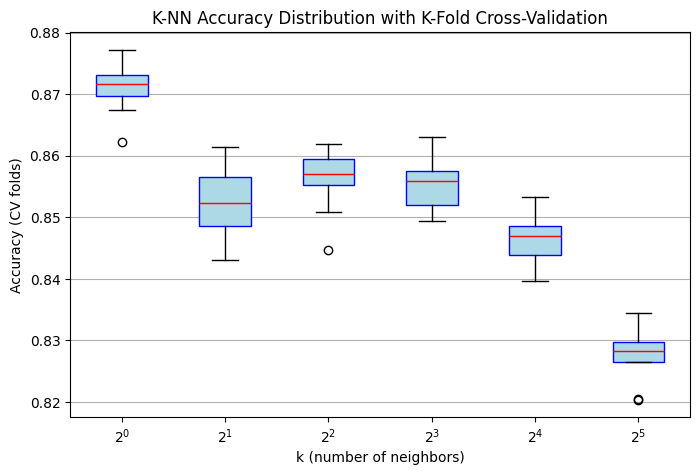

In [83]:
plt.figure(figsize=(8, 5))
plt.boxplot(
    all_scores,
    positions=range(len(k_values)),
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    medianprops=dict(color='red')
)

plt.xticks(
    range(len(k_values)),
    [f"$2^{i}$" for i in range(len(k_values))]
)
plt.xlabel('k (number of neighbors)')
plt.ylabel('Accuracy (CV folds)')
plt.title('K-NN Accuracy Distribution with K-Fold Cross-Validation')
plt.grid(True, axis='y')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Get precision and recall for each class
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_best, zero_division=0)

plt.figure(figsize=(7, 6))
plt.scatter(recall, precision, s=100, c='b')
for i, class_name in enumerate(class_names):
    plt.text(recall[i]+0.01, precision[i], class_name, fontsize=12)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision vs Recall (Best KNN, n_neighbors={best_n})')
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()

In [ ]:
# Find the True positives for false positives for a particular probability theshold using the best KNN model

#### K-NN WITH PCA REDUCTION

Original data - n_neighbors=1: accuracy=0.8627
Original data - n_neighbors=2: accuracy=0.8447
Original data - n_neighbors=4: accuracy=0.8578
Original data - n_neighbors=8: accuracy=0.8551
Original data - n_neighbors=16: accuracy=0.8425
Original data - n_neighbors=32: accuracy=0.8201
Original data - n_neighbors=64: accuracy=0.7934
Original data - n_neighbors=128: accuracy=0.7467
Original data - n_neighbors=256: accuracy=0.6928
Original data - n_neighbors=512: accuracy=0.6274
Original data - n_neighbors=1024: accuracy=0.5648
Original data - n_neighbors=2048: accuracy=0.5169
Original data - n_neighbors=4096: accuracy=0.4612
PCA-16D - n_neighbors=1: accuracy=0.8304
PCA-16D - n_neighbors=2: accuracy=0.8112
PCA-16D - n_neighbors=4: accuracy=0.8295
PCA-16D - n_neighbors=8: accuracy=0.8285
PCA-16D - n_neighbors=16: accuracy=0.8193
PCA-16D - n_neighbors=32: accuracy=0.8010
PCA-16D - n_neighbors=64: accuracy=0.7691
PCA-16D - n_neighbors=128: accuracy=0.7276
PCA-16D - n_neighbors=256: accuracy=0.

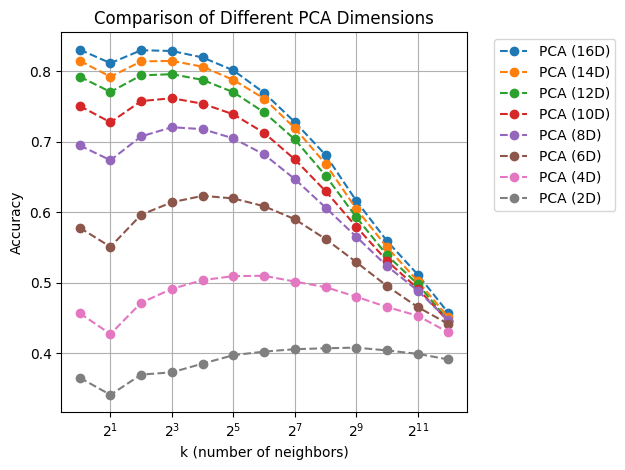

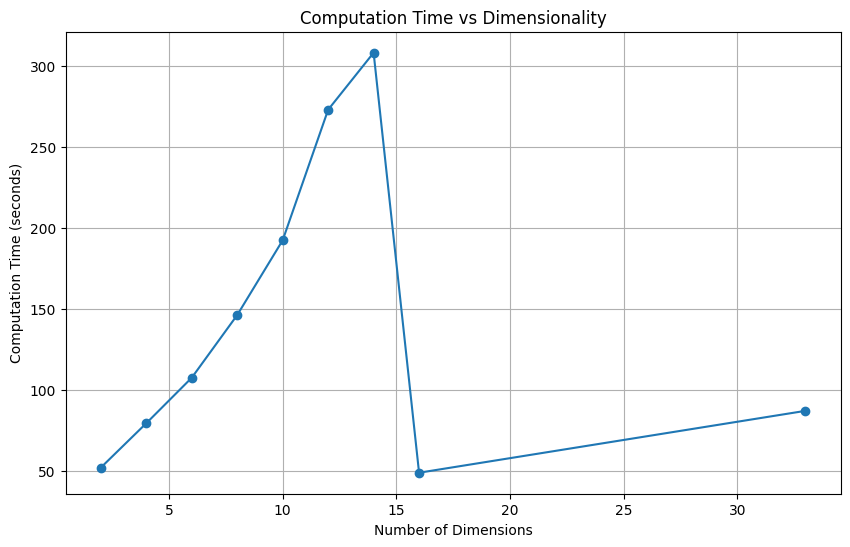


Computation times:
Original (33D): 87.32 seconds
PCA-16D: 49.16 seconds
PCA-14D: 308.20 seconds
PCA-12D: 273.05 seconds
PCA-10D: 192.54 seconds
PCA-8D: 146.42 seconds
PCA-6D: 107.78 seconds
PCA-4D: 79.70 seconds
PCA-2D: 52.33 seconds


In [84]:
# Compare K-NN performance with different PCA dimensions
pca_dimensions = [16, 14, 12, 10, 8, 6, 4, 2]
n_neighbors_list = [2**i for i in range(13)]
results_multi_pca = {d: [] for d in pca_dimensions}
computation_times = {}

# First run KNN on original data
start_time = time.time()
results_original = []

for n in n_neighbors_list:
    try:
        accuracy, loss, knn = run_knn_from_split(
            X_train_scaled, 
            X_test_scaled,
            y_train_encoded,
            y_test_encoded,
            n_neighbors=n, 
            class_names=class_names, 
            label_name="Original (33D)"
        )
        results_original.append({'n_neighbors': n, 'accuracy': accuracy, 'loss': loss})
        print(f"Original data - n_neighbors={n}: accuracy={accuracy:.4f}")
    except ValueError as e:
        print(f"Original data - n_neighbors={n}: Error - {e}")

computation_times[33] = time.time() - start_time

# Prepare all PCA transformations first
pca_data = {}
for n_components in pca_dimensions:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    pca_data[n_components] = (X_train_pca, X_test_pca)

# Run KNN for each PCA dimension
for n_components in pca_dimensions:
    X_train_pca, X_test_pca = pca_data[n_components]
    
    # Start timing only K-NN part
    start_time = time.time()
    
    for n in n_neighbors_list:
        try:
            accuracy, loss, knn = run_knn_from_split(
                X_train_pca, 
                X_test_pca,
                y_train_encoded,
                y_test_encoded,
                n_neighbors=n, 
                class_names=class_names, 
                label_name=f"PCA-{n_components}D"
            )
            results_multi_pca[n_components].append(
                {'n_neighbors': n, 'accuracy': accuracy, 'loss': loss}
            )
            print(f"PCA-{n_components}D - n_neighbors={n}: accuracy={accuracy:.4f}")
        except ValueError as e:
            print(f"PCA-{n_components}D - n_neighbors={n}: Error - {e}")
    
    # Record only K-NN computation time
    computation_times[n_components] = time.time() - start_time
    
    # Plot results for this PCA dimension
    plt.plot([r['n_neighbors'] for r in results_multi_pca[n_components]],
             [r['accuracy'] for r in results_multi_pca[n_components]],
             marker='o', label=f'PCA ({n_components}D)', linestyle='--')

plt.xscale('log', base=2)
plt.xlabel('k (number of neighbors)')
plt.ylabel('Accuracy')
plt.title(f'Comparison of Different PCA Dimensions')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot computation times
plt.figure(figsize=(10, 6))
sorted_dimensions = sorted(computation_times.keys(), reverse=True)  # Sort dimensions in descending order
times = [computation_times[d] for d in sorted_dimensions]
plt.plot(sorted_dimensions, times, marker='o')
plt.xlabel('Number of Dimensions')
plt.ylabel('Computation Time (seconds)')
plt.title('Computation Time vs Dimensionality')
plt.grid(True)
plt.show()

# Print computation times
print("\nComputation times:")
print(f"Original (33D): {computation_times[33]:.2f} seconds")
for dim in pca_dimensions:
    print(f"PCA-{dim}D: {computation_times[dim]:.2f} seconds")

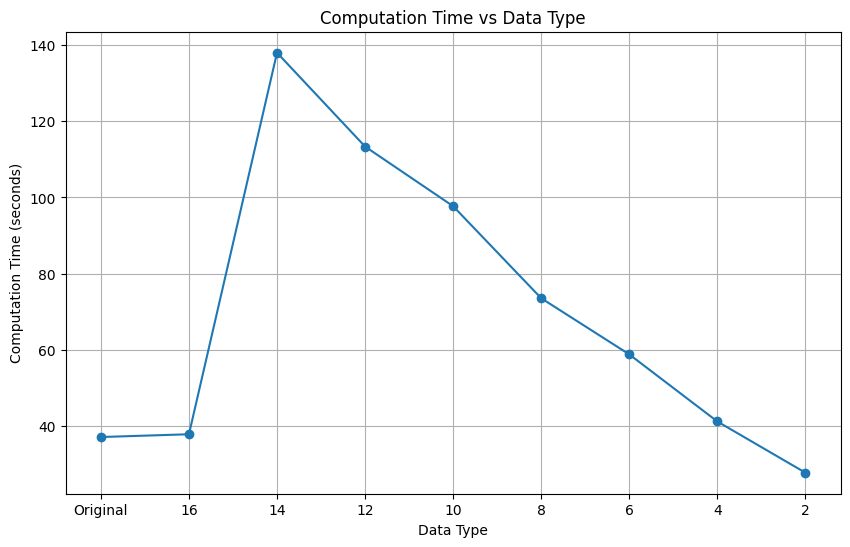

In [ ]:
# Measure time for original data
start_time_original = time.time()
for n in n_neighbors_list:
    try:
        accuracy, loss, knn = run_knn_from_split(
            X_train_scaled, 
            X_test_scaled,
            y_train_encoded,
            y_test_encoded,
            n_neighbors=n, 
            class_names=class_names, 
            label_name=label_of_interest
        )
    except ValueError as e:
        print(f"Original data - n_neighbors={n}: Error - {e}")
original_time = time.time() - start_time_original

# Append to computation times
computation_times[33] = original_time

# Graph all the computation times
plt.figure(figsize=(10, 6))
plt.plot(['Original'] + dimensions, [original_time] + times, marker='o')
plt.xlabel('Data Type')
plt.ylabel('Computation Time (seconds)')
plt.title('Computation Time vs Data Type')
plt.grid(True)
plt.show()



#### K-NN ROC curve

Best fold accuracy: 0.8772


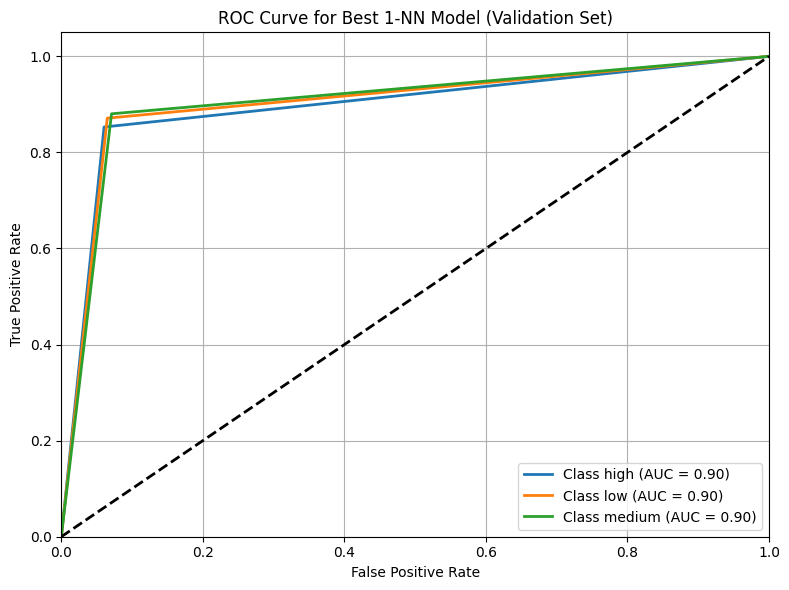

In [85]:
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for cross-validation (already in your code)
X_kfold = np.vstack((X_train, X_test))
y_fold = np.hstack((y_train, y_test))
X_kfold_scaled = scaler.fit_transform(X_kfold)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store models and scores for k=1
models = []
scores = []

for train_idx, test_idx in cv.split(X_kfold_scaled, y_fold):
    X_tr, X_te = X_kfold_scaled[train_idx], X_kfold_scaled[test_idx]
    y_tr, y_te = y_fold[train_idx], y_fold[test_idx]
    # Pipeline with SMOTE and 1-NN
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=1))
    ])
    pipeline.fit(X_tr, y_tr)
    acc = pipeline.score(X_te, y_te)
    models.append(pipeline)
    scores.append(acc)

# Find the best model (highest accuracy on its fold)
best_idx = np.argmax(scores)
best_model = models[best_idx]
print(f"Best fold accuracy: {scores[best_idx]:.4f}")

# Use the best model to predict probabilities on the validation set
y_val_proba = best_model.predict_proba(X_val_scaled)

# Binarize y_val for multiclass ROC
lb = LabelBinarizer()
y_val_binarized = lb.fit_transform(y_val)
if y_val_binarized.shape[1] == 1:
    y_val_binarized = np.hstack([1 - y_val_binarized, y_val_binarized])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_val_binarized.shape[1]):
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_val_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {lb.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best 1-NN Model (Validation Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### K-NN Confusion Matrix

<Figure size 600x500 with 0 Axes>

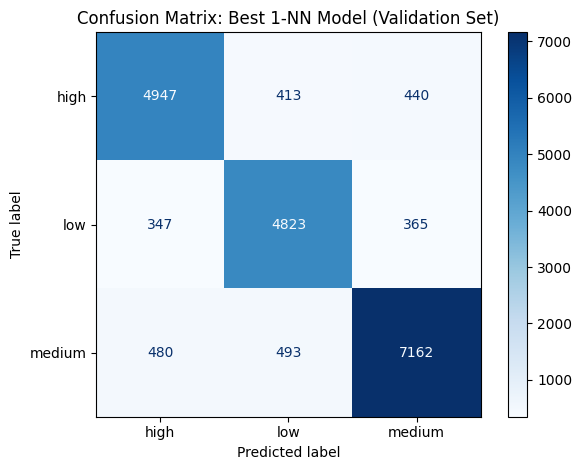

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the validation set
y_val_pred = best_model.predict(X_val_scaled)

# If you used label encoding, ensure y_val_pred and y_val are comparable
# If y_val is not encoded, encode it with the same encoder as used in training
# Example:
# y_val_encoded = le.transform(y_val)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=best_model.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: Best 1-NN Model (Validation Set)')
plt.tight_layout()
plt.show()

### K-MEANS ALGORITHM

In [ ]:
# # Run k-means with a guessed number of clusters (e.g., 3)
# k = 3
# kmeans = KMeans(n_clusters=k, random_state=42)
# cluster_labels = kmeans.fit_predict(X_scaled)

# # Evaluate clustering with silhouette score
# sil_score = silhouette_score(X_scaled, cluster_labels)

# # Prepare dataframe for plotting
# pca_df = pd.DataFrame({
#     'PC1': X_pca[:, 0],
#     'PC2': X_pca[:, 1],
#     'Cluster': cluster_labels
# })

# # Plot PCA-reduced features colored by cluster
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2')
# plt.title(f'K-Means Clustering (k={k}) on PCA-Reduced Features\nSilhouette Score = {sil_score:.2f}')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend(title='Cluster')
# plt.tight_layout()
# plt.show()

In [ ]:
# Perform k-Means clustering on the original features
# Encode weight labels as integers for evaluation
from sklearn.preprocessing import LabelEncoder
current_label_of_interest = 'handedness'
cluster_numbers = 2
weight_encoded = LabelEncoder().fit_transform(labels_df[current_label_of_interest])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Choose k=3 for the three weight categories
k = cluster_numbers
kmeans = KMeans(n_clusters=k, random_state=1)
cluster_labels = kmeans.fit_predict(X_scaled)

# Compare clusters to actual weight catWegories
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix (clusters vs. true weight categories):")
print(confusion_matrix(weight_encoded, cluster_labels))

print("\nClassification Report (clusters vs. true weight categories):")
print(classification_report(weight_encoded, cluster_labels, target_names=LabelEncoder().fit(labels_df[current_label_of_interest]).classes_))


Confusion Matrix (clusters vs. true weight categories):
[[ 1914 14191]
 [11521 69729]]

Classification Report (clusters vs. true weight categories):
              precision    recall  f1-score   support

           0       0.14      0.12      0.13     16105
           1       0.83      0.86      0.84     81250

    accuracy                           0.74     97355
   macro avg       0.49      0.49      0.49     97355
weighted avg       0.72      0.74      0.73     97355



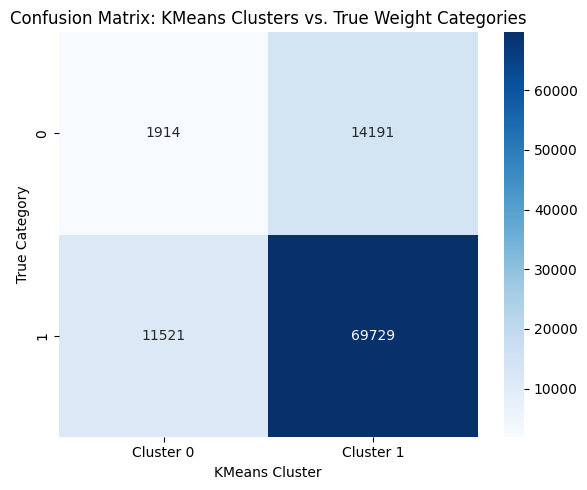

In [ ]:
# Plot the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(weight_encoded, cluster_labels)
weight_classes = LabelEncoder().fit(labels_df[current_label_of_interest]).classes_

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Cluster {i}' for i in range(cm.shape[1])],
            yticklabels=weight_classes)
plt.xlabel('KMeans Cluster')
plt.ylabel('True Category')
plt.title('Confusion Matrix: KMeans Clusters vs. True Weight Categories')
plt.tight_layout()
plt.show()

In [ ]:
# Perform k-Means clustering on the top 16D PCA-reduced features
# Encode weight labels as integers for evaluation
from sklearn.preprocessing import LabelEncoder
weight_encoded = LabelEncoder().fit_transform(labels_df[current_label_of_interest])

# Run KMeans on the 16D PCA-reduced features
k = cluster_numbers
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_features_16)

# Compare clusters to actual weight categories
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix (clusters vs. true categories):")
print(confusion_matrix(weight_encoded, cluster_labels))

print("\nClassification Report (clusters vs. true categories):")
print(classification_report(weight_encoded, cluster_labels, target_names=LabelEncoder().fit(labels_df[current_label_of_interest]).classes_))


Confusion Matrix (clusters vs. true categories):
[[14192  1913]
 [69735 11515]]

Classification Report (clusters vs. true categories):
              precision    recall  f1-score   support

           0       0.17      0.88      0.28     16105
           1       0.86      0.14      0.24     81250

    accuracy                           0.26     97355
   macro avg       0.51      0.51      0.26     97355
weighted avg       0.74      0.26      0.25     97355



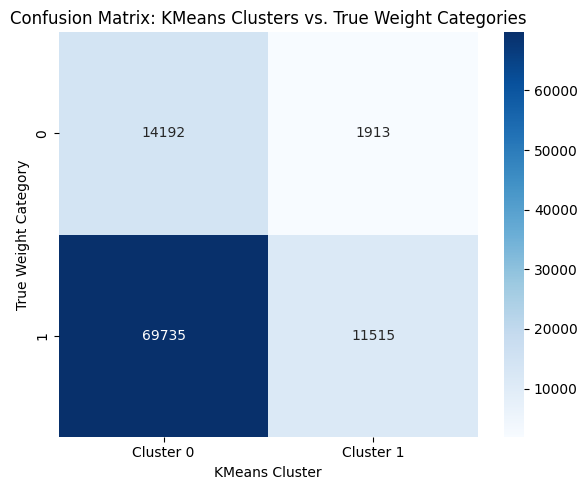

In [ ]:
# Plot the confusion matrix for the 16D PCA-reduced features
# Compute the confusion matrix
cm = confusion_matrix(weight_encoded, cluster_labels)
weight_classes = LabelEncoder().fit(labels_df[current_label_of_interest]).classes_

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Cluster {i}' for i in range(cm.shape[1])],
            yticklabels=weight_classes)
plt.xlabel('KMeans Cluster')
plt.ylabel('True Weight Category')
plt.title('Confusion Matrix: KMeans Clusters vs. True Weight Categories')
plt.tight_layout()
plt.show()

In [ ]:
# Perform k-Means clustering on the top 2D PCA-reduced features
# Encode weight labels as integers for evaluation
from sklearn.preprocessing import LabelEncoder
weight_encoded = LabelEncoder().fit_transform(labels_df[current_label_of_interest])

# Run KMeans on the 16D PCA-reduced features
k = cluster_numbers
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_features)

# Compare clusters to actual weight categories
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix (clusters vs. true weight categories):")
print(confusion_matrix(weight_encoded, cluster_labels))

print("\nClassification Report (clusters vs. true weight categories):")
print(classification_report(weight_encoded, cluster_labels, target_names=LabelEncoder().fit(labels_df[current_label_of_interest]).classes_))


Confusion Matrix (clusters vs. true weight categories):
[[14203  1902]
 [69727 11523]]

Classification Report (clusters vs. true weight categories):
              precision    recall  f1-score   support

           0       0.17      0.88      0.28     16105
           1       0.86      0.14      0.24     81250

    accuracy                           0.26     97355
   macro avg       0.51      0.51      0.26     97355
weighted avg       0.74      0.26      0.25     97355



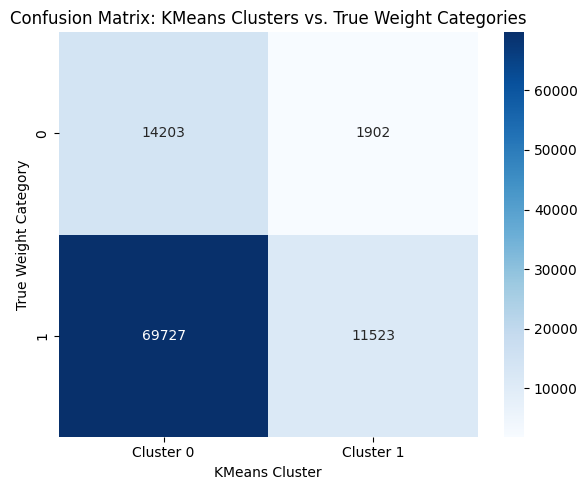

In [ ]:
# Plot the confusion matrix for the 2D PCA-reduced features
# Compute the confusion matrix
cm = confusion_matrix(weight_encoded, cluster_labels)
weight_classes = LabelEncoder().fit(labels_df[current_label_of_interest]).classes_

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Cluster {i}' for i in range(cm.shape[1])],
            yticklabels=weight_classes)
plt.xlabel('KMeans Cluster')
plt.ylabel('True Weight Category')
plt.title('Confusion Matrix: KMeans Clusters vs. True Weight Categories')
plt.tight_layout()
plt.show()

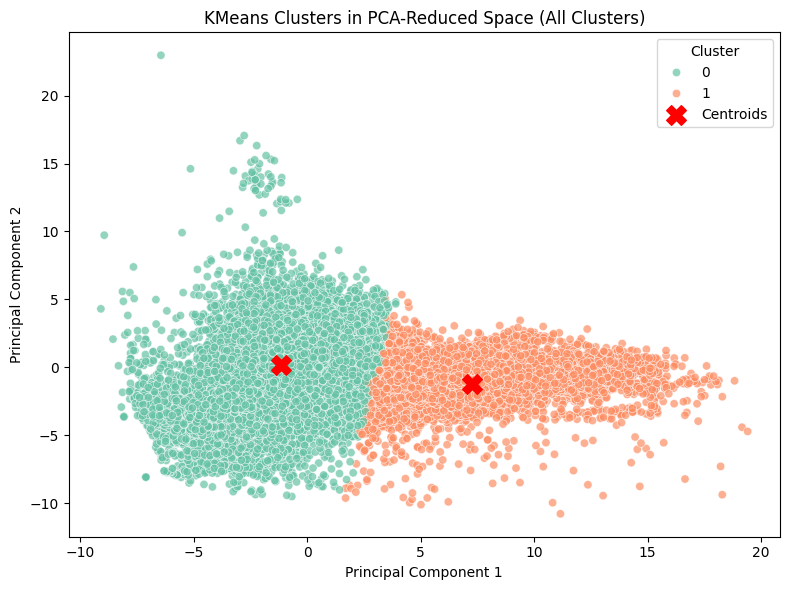

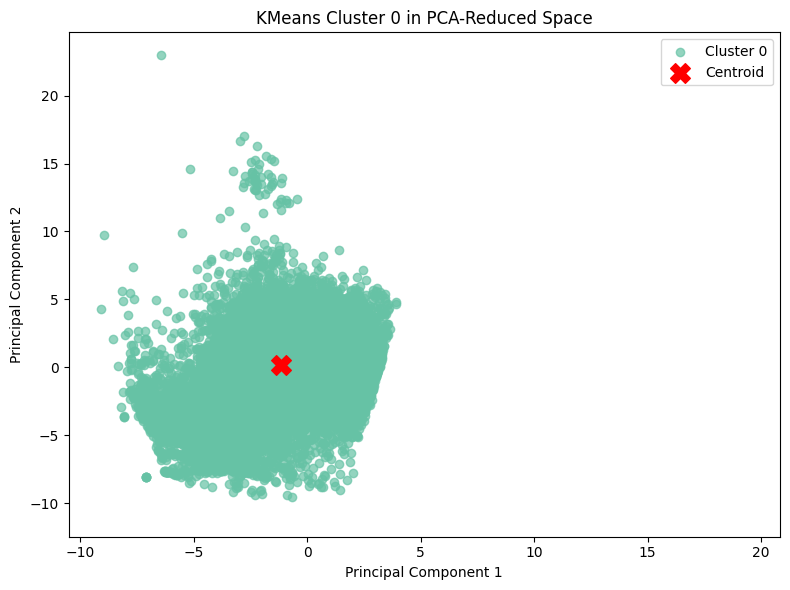

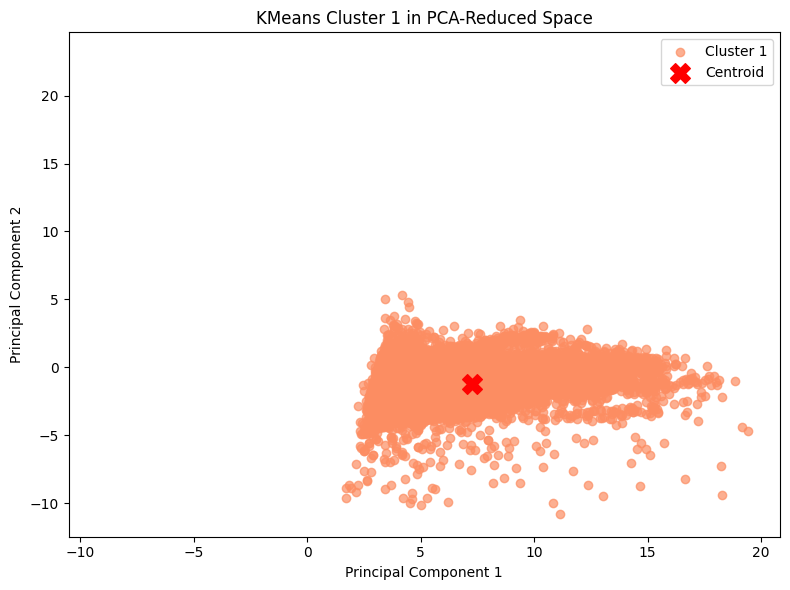

In [ ]:
# Reduce to 2D with PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Run KMeans clustering (k=3 for weight categories)
k = cluster_numbers
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Get cluster centers in PCA space
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

# Define the color palette and cluster count
palette = sns.color_palette('Set2', n_colors=k)

# Plot all clusters together and get axis limits
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette=palette, alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title('KMeans Clusters in PCA-Reduced Space (All Clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
# Get axis limits
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.show()

# Plot each cluster separately with matching color and same axis limits
for cluster_id in range(k):
    plt.figure(figsize=(8, 6))
    mask = (cluster_labels == cluster_id)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], color=palette[cluster_id], alpha=0.7, label=f'Cluster {cluster_id}')
    plt.scatter(centroids_pca[cluster_id, 0], centroids_pca[cluster_id, 1], s=200, c='red', marker='X', label='Centroid')
    plt.title(f'KMeans Cluster {cluster_id} in PCA-Reduced Space')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend()
    plt.tight_layout()
    plt.show()

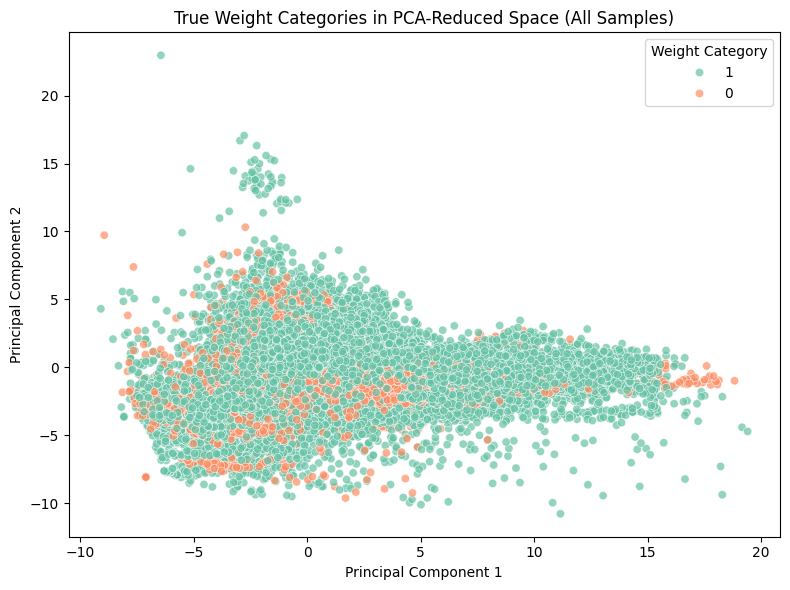

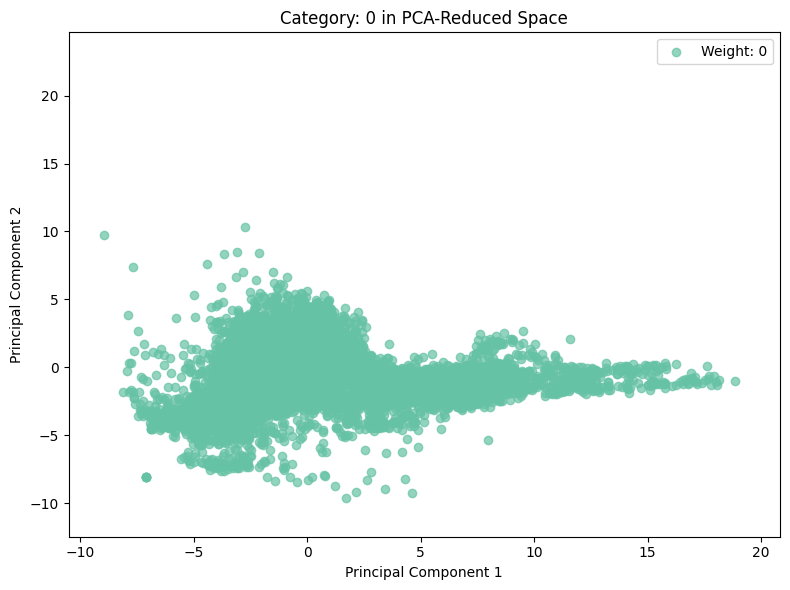

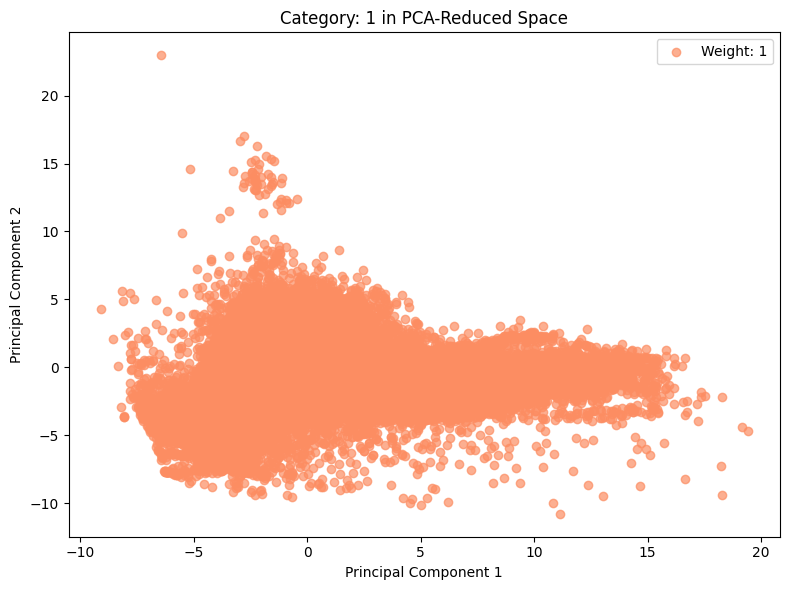

In [ ]:
# Encode weight categories as integers for coloring
weight_labels = labels_df[current_label_of_interest].values
weight_encoded = LabelEncoder().fit_transform(weight_labels)
weight_classes = LabelEncoder().fit(labels_df[current_label_of_interest]).classes_
palette_weights = sns.color_palette('Set2', n_colors=len(weight_classes))

# Plot all weight categories together using the same axis limits as before
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=weight_labels, palette=palette_weights, alpha=0.7)
plt.title('True Weight Categories in PCA-Reduced Space (All Samples)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Weight Category')
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()
plt.show()

# Plot each weight category separately with matching color and same axis limits
for idx, weight_class in enumerate(weight_classes):
    plt.figure(figsize=(8, 6))
    mask = (weight_labels == weight_class)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], color=palette_weights[idx], alpha=0.7, label=f'Weight: {weight_class}')
    plt.title(f'Category: {weight_class} in PCA-Reduced Space')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend()
    plt.tight_layout()
    plt.show()